In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import warnings
from datetime import datetime, timedelta
import shap
import matplotlib.pyplot as plt

# Configuración de visualización
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
shap.initjs() # Inicializar gráficos JS para SHAP en el notebook

# --- Constantes Globales ---
RUTA_VENTAS = 'ventas_consolidada_2023-01_2025-12-14.csv'
RUTA_CALENDARIO = 'calendario.csv'
COLUMNA_OBJETIVO = 'UNIDADES_VENDIDAS'
DIAS_A_PREDECIR = 20

In [9]:
print(f"Cargando datos de ventas desde {RUTA_VENTAS}...")
try:
    df_ventas = pd.read_csv(RUTA_VENTAS)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo {RUTA_VENTAS}. Asegúrate de tener el CSV.")
    # Creación de datos dummy para que el código no falle si lo pruebas sin archivo
    # (Borra esto si tienes tus datos reales)
    df_ventas = pd.DataFrame({
        'FECHA': pd.date_range(start='2023-01-01', end='2024-10-01', freq='D').tolist() * 5,
        'CATEGORIA': ['Categoria A'] * 640 * 5,
        'PRODUCTO': ['Prod 1'] * 640 + ['Prod 2'] * 640 + ['Prod 3'] * 640 + ['Prod 4'] * 640 + ['Prod 5'] * 640,
        'TOTAL': np.random.rand(3200) * 100,
        'CANTIDAD': np.random.randint(0, 10, 3200)
    })

# 1. Limpieza y Conversión Inicial
df_ventas['FECHA'] = pd.to_datetime(df_ventas['FECHA']).dt.date
df_ventas = df_ventas[~df_ventas['CATEGORIA'].isin(['General', 'Pedidos Especiales'])]

# 2. Agregación a nivel de Producto-Día
print("Agregando transacciones a nivel (Fecha, Categoria, Producto)...")
df_agg = df_ventas.groupby(
    [df_ventas['FECHA'], 'CATEGORIA', 'PRODUCTO']
).agg(
    TOTAL_VENTAS=('TOTAL', 'sum'),
    UNIDADES_VENDIDAS=('CANTIDAD', 'sum')
).reset_index()

df_agg.rename(columns={'FECHA': 'fecha'}, inplace=True)
df_agg['fecha'] = pd.to_datetime(df_agg['fecha'])

# 3. Creación del Panel Completo (Relleno de Ceros)
print("Creando panel de series temporales completo...")
items_validos = df_agg[['PRODUCTO','CATEGORIA']].drop_duplicates()
fecha_min = df_agg['fecha'].min()
fecha_max = df_agg['fecha'].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

malla = pd.DataFrame({'fecha': rango_fechas}).merge(items_validos, how='cross')
indice_completo = pd.MultiIndex.from_frame(malla)

df_completo = (df_agg.set_index(['fecha', 'PRODUCTO','CATEGORIA'])
                 .reindex(indice_completo, fill_value=0)
                 .reset_index())

Cargando datos de ventas desde ventas_consolidada_2023-01_2025-12-14.csv...
Agregando transacciones a nivel (Fecha, Categoria, Producto)...
Creando panel de series temporales completo...


In [ ]:
def crear_caracteristicas_calendario(df):
    df_feat = df.copy()
    df_feat['fecha'] = pd.to_datetime(df_feat['fecha'])
    df_feat['dia_de_la_semana'] = df_feat['fecha'].dt.dayofweek
    df_feat['dia_del_mes'] = df_feat['fecha'].dt.day
    df_feat['mes'] = df_feat['fecha'].dt.month
    df_feat['anio'] = df_feat['fecha'].dt.year
    return df_feat

def crear_caracteristicas_ciclicas(df):
    df_feat = df.copy()
    # Ciclos semanales, mensuales y diarios
    df_feat['dia_semana_sin'] = np.sin(2 * np.pi * df_feat['dia_de_la_semana'] / 7) 
    df_feat['dia_semana_cos'] = np.cos(2 * np.pi * df_feat['dia_de_la_semana'] / 7)
    df_feat['mes_sin'] = np.sin(2 * np.pi * df_feat['mes'] / 12) 
    df_feat['mes_cos'] = np.cos(2 * np.pi * df_feat['mes'] / 12)
    df_feat['dia_mes_sin'] = np.sin(2 * np.pi * df_feat['dia_del_mes'] / 31) 
    df_feat['dia_mes_cos'] = np.cos(2 * np.pi * df_feat['dia_del_mes'] / 31) 
    return df_feat

def _aplicar_ventana_ponderada(df_features, fechas_base, nombre_col, ponderaciones):
    if nombre_col not in df_features.columns:
        df_features[nombre_col] = 0.0
    fechas_base_dt = pd.to_datetime(fechas_base)
    for fecha_base in fechas_base_dt:
        for offset_dias, peso in ponderaciones.items():
            fecha_objetivo = fecha_base + pd.Timedelta(days=offset_dias)
            df_features.loc[df_features['fecha']==fecha_objetivo, nombre_col] = peso
    return df_features

def crear_caracteristicas_eventos(df, ruta_calendario):
    df_feat = df.copy()
    try:
        df_calendario = pd.read_csv(ruta_calendario) 
        df_calendario['Fecha'] = pd.to_datetime(df_calendario['Fecha'], format='%d/%m/%Y')
        fechas_puente = set(df_calendario[df_calendario['Tipo'] == 'Oficial - Puente']['Fecha'])
        fechas_nomina = set(df_calendario[df_calendario['Tipo'] == 'Nómina']['Fecha'])
    except:
        fechas_puente = set()
        fechas_nomina = set()

    df_feat['es_puente'] = df_feat['fecha'].isin(fechas_puente).astype(int)
    df_feat['es_nomina'] = df_feat['fecha'].isin(fechas_nomina).astype(int)

    ponderaciones_clave = {-3: 0.3, -2: 0.6, -1: 0.9, 0: 1.0, 1: 0.5} 
    fechas_madre = ['2023-05-10', '2024-05-10', '2025-05-10', '2026-05-10']
    df_feat = _aplicar_ventana_ponderada(df_feat, fechas_madre, 'impacto_dia_madre', ponderaciones_clave)
    
    # Día del Padre (3er Dom Junio)
    fechas_padre = ['2023-06-18', '2024-06-16', '2025-06-15','2026-06-21']
    df_feat = _aplicar_ventana_ponderada(df_feat, fechas_padre, 'impacto_dia_padre', ponderaciones_clave)
    
    # Día de los Abuelos (28 de Agosto)
    fechas_abuelos = ['2023-08-28', '2024-08-28', '2025-08-28', '2026-08-28']
    df_feat = _aplicar_ventana_ponderada(df_feat, fechas_abuelos, 'impacto_dia_abuelos', ponderaciones_clave)
    
    # Navidad (24 de Diciembre)
    fechas_navidad = ['2023-12-24', '2024-12-24', '2025-12-24', '2026-12-24']
    df_feat = _aplicar_ventana_ponderada(df_feat, fechas_navidad, 'impacto_dia_navidad', ponderaciones_clave)
    
    # Fin de Año (31 de Diciembre)
    fechas_fin_anio = ['2023-12-31', '2024-12-31', '2025-12-31', '2026-12-31']
    df_feat = _aplicar_ventana_ponderada(df_feat, fechas_fin_anio, 'impacto_dia_fin', ponderaciones_clave)
    
    return df_feat

def crear_estadisticas_por_producto(df):
    df = df.sort_values(by=['PRODUCTO', 'fecha'])
    
    # Lags (Retardos)
    df['lag_7d_total'] = df.groupby(['PRODUCTO'])['TOTAL_VENTAS'].shift(7)
    df['lag_14d_total'] = df.groupby(['PRODUCTO'])['TOTAL_VENTAS'].shift(14)
    df['lag_28d_total'] = df.groupby(['PRODUCTO'])['TOTAL_VENTAS'].shift(21)
    df['lag_1d_total'] = df.groupby(['PRODUCTO'])['TOTAL_VENTAS'].shift(1)

    # Medias Móviles (Rolling)
    g = df.groupby(['PRODUCTO'])['TOTAL_VENTAS'].shift(1) # Shift 1 para evitar fuga de datos
    df['rolling_mean_7d_total'] = g.rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_mean_14d_total'] = g.rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_mean_28d_total'] = g.rolling(window=28, min_periods=1).mean().reset_index(0, drop=True)
    
    df = df.fillna(0)
    return df

In [11]:
print("Aplicando ingeniería de características inicial...")
df_features = crear_caracteristicas_calendario(df_completo)
df_features = crear_caracteristicas_ciclicas(df_features)
df_features = crear_caracteristicas_eventos(df_features, RUTA_CALENDARIO)
df_features = crear_estadisticas_por_producto(df_features)

Aplicando ingeniería de características inicial...


In [12]:

def entrenar_modelo_final(df_features, categoria):
    print(f"Entrenando: {categoria}...")
    df_cat = df_features[df_features['CATEGORIA'] == categoria].copy()
    
    # Configuración de categóricas para XGBoost
    categorical_cols = ['CATEGORIA','PRODUCTO']
    for col in categorical_cols:
        df_cat[col] = df_cat[col].astype('category')
    
    cols_ignorar = ['prediccion', 'real', 'TOTAL_VENTAS', 'fecha'] 
    features_cols = [c for c in df_cat.columns if c not in [COLUMNA_OBJETIVO] + cols_ignorar]
    
    X = df_cat[features_cols]
    y = df_cat[COLUMNA_OBJETIVO]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000, 
        learning_rate=0.01,
        max_depth=6,
        tree_method="approx", 
        enable_categorical=True,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(X, y)
    return model, features_cols

# Entrenamiento
modelos_por_categoria = {}
features_por_categoria = {}
categorias_principales = df_features['CATEGORIA'].unique()

for categoria in categorias_principales:
    if categoria == 0: continue
    model, feats = entrenar_modelo_final(df_features, categoria)
    modelos_por_categoria[categoria] = model
    features_por_categoria[categoria] = feats

print("¡Entrenamiento completado!")

Entrenando: Galletas...
Entrenando: Panadería...
Entrenando: Repostería Individual...
Entrenando: Accesorios...
Entrenando: Empanada...
Entrenando: Gelatinas y Flanes...
Entrenando: Especial de Temporada...
Entrenando: Pastelería Mantequilla...
Entrenando: Pastelería Crema...
¡Entrenamiento completado!


In [13]:
print("Iniciando Forecast Recursivo...")
ultima_fecha = df_features['fecha'].max()
df_history = df_features.copy()
items_unicos = df_history[['PRODUCTO', 'CATEGORIA']].drop_duplicates()

for i in range(1, DIAS_A_PREDECIR + 1):
    fecha_futura = ultima_fecha + timedelta(days=i)
    
    # 1. Crear esqueleto del día futuro
    df_dia_futuro = items_unicos.copy()
    df_dia_futuro['fecha'] = fecha_futura
    df_dia_futuro[COLUMNA_OBJETIVO] = 0 
    df_dia_futuro['TOTAL_VENTAS'] = 0 
    
    # 2. Concatenar
    df_history = pd.concat([df_history, df_dia_futuro], ignore_index=True)
    
    # 3. Recalcular features (Lento pero necesario para lags correctos)
    # Optimización: Solo recalcular para la ventana necesaria si el dataset es gigante
    df_history = crear_caracteristicas_calendario(df_history)
    df_history = crear_caracteristicas_ciclicas(df_history)
    df_history = crear_caracteristicas_eventos(df_history, RUTA_CALENDARIO)
    df_history = crear_estadisticas_por_producto(df_history)
    
    # 4. Predecir
    mask_dia_actual = df_history['fecha'] == fecha_futura
    
    for categoria in categorias_principales:
        if categoria not in modelos_por_categoria: continue
        
        mask_cat = (df_history['CATEGORIA'] == categoria) & mask_dia_actual
        df_subset = df_history[mask_cat].copy()
        
        if len(df_subset) == 0: continue
        
        # Ajustar tipos
        for col in ['CATEGORIA', 'PRODUCTO']:
            df_subset[col] = df_subset[col].astype('category')
            
        X_future = df_subset[features_por_categoria[categoria]]
        preds = modelos_por_categoria[categoria].predict(X_future)
        preds = np.maximum(preds, 0) # No ventas negativas
        
        # Guardar predicción
        df_history.loc[mask_cat & mask_dia_actual, COLUMNA_OBJETIVO] = preds
        df_history.loc[mask_cat & mask_dia_actual, 'TOTAL_VENTAS'] = preds 

print(f"Forecast generado hasta: {df_history['fecha'].max()}")

Iniciando Forecast Recursivo...
Forecast generado hasta: 2026-01-03 00:00:00


In [14]:
def explicar_prediccion_individual(fecha_str, producto_nombre, df_datos, modelos, features_dict):
    """
    Muestra un gráfico Waterfall de SHAP explicando qué factores contribuyeron 
    a la predicción de un producto en una fecha específica.
    """
    fecha_target = pd.to_datetime(fecha_str)
    
    # 1. Buscar la fila correspondiente
    mask = (df_datos['fecha'] == fecha_target) & (df_datos['PRODUCTO'] == producto_nombre)
    fila = df_datos[mask]
    
    if len(fila) == 0:
        print(f"No se encontraron datos para {producto_nombre} en {fecha_str}")
        return

    categoria = fila['CATEGORIA'].iloc[0]
    valor_predicho = fila[COLUMNA_OBJETIVO].iloc[0]
    
    print(f"--- Análisis de Predicción ---")
    print(f"Producto: {producto_nombre}")
    print(f"Fecha: {fecha_str}")
    print(f"Categoría: {categoria}")
    print(f"Predicción Modelo: {valor_predicho:.2f} unidades")
    
    # 2. Recuperar modelo y features
    if categoria not in modelos:
        print("Modelo no encontrado para esta categoría.")
        return
        
    modelo = modelos[categoria]
    cols = features_dict[categoria]
    
    # 3. Preparar datos X
    X_fila = fila[cols].copy()
    for col in ['CATEGORIA', 'PRODUCTO']:
        X_fila[col] = X_fila[col].astype('category')
        # Sincronizar categorías con el modelo (truco para XGBoost categorical)
        # En producción idealmente se usa un encoder persistente
    
    # 4. Calcular SHAP values
    # Para XGBoost con categóricas, a veces se requiere DMatrix o TreeExplainer directo
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer(X_fila)
    
    # 5. Visualizar
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_values[0], max_display=15, show=False)
    plt.title(f"¿Por qué {valor_predicho:.1f}? Factores para {producto_nombre} el {fecha_str}")
    plt.show()

--- Análisis de Predicción ---
Producto: Pastel Fresas c/Crema Chico
Fecha: 2025-12-24
Categoría: Pastelería Crema
Predicción Modelo: 14.39 unidades


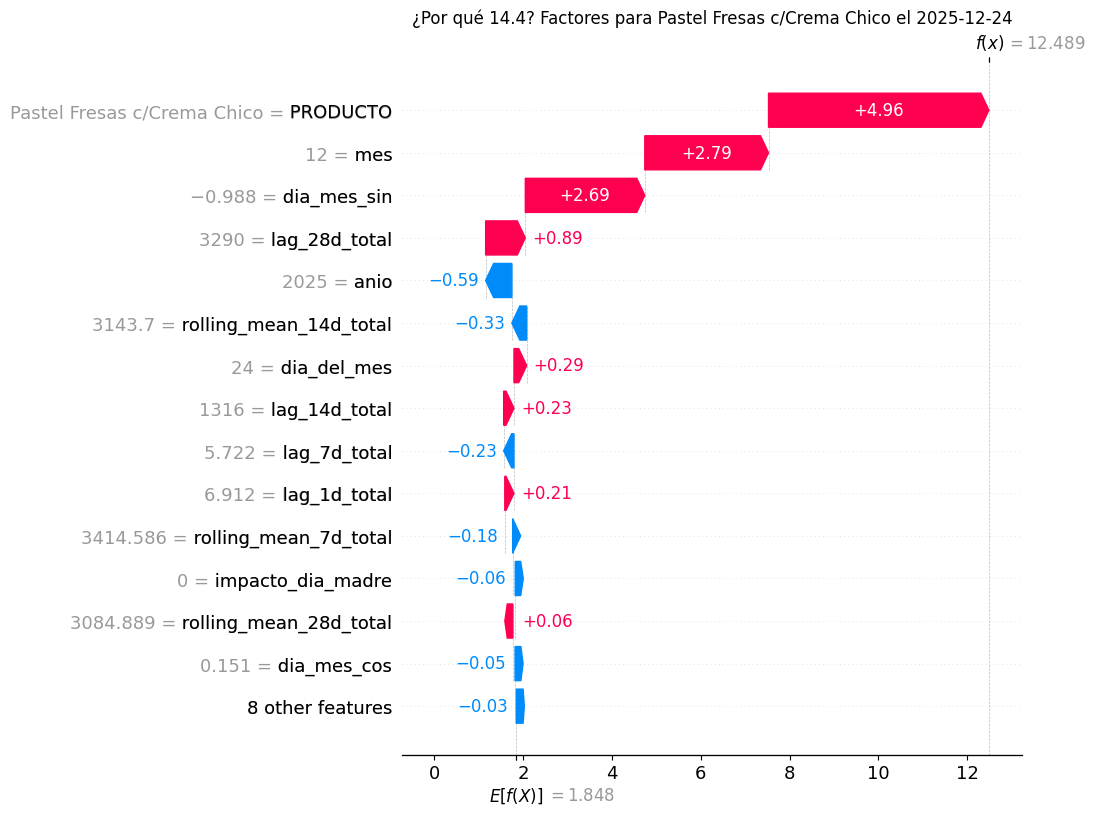

In [20]:
# --- Ejemplo de uso ---
# Tomamos una fecha del futuro generado (ej. 5 días después de la última real)
fecha_ejemplo = (ultima_fecha + timedelta(days=10)).strftime('%Y-%m-%d')
producto_ejemplo = df_features['PRODUCTO'].unique()[0] # Tomamos el primer producto disponible
producto_ejemplo = 'Pastel Fresas c/Crema Chico'

explicar_prediccion_individual(
    fecha_str=fecha_ejemplo,
    producto_nombre=producto_ejemplo,
    df_datos=df_history,
    modelos=modelos_por_categoria,
    features_dict=features_por_categoria
)

In [17]:
producto_ejemplo
fecha_ejemplo

'2025-12-19'